In [1]:
from __future__ import division

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import time
import sys
sys.path.insert(0, '..')

import random
import numpy as np
import pandas as pd
from collections import deque
from scipy.integrate import odeint

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter

from algs.td3 import Agent_TD3
from envs.env import SimpleEnv
from cfgs.config import GetParameters

In [2]:
args = GetParameters()
args.model_dir = '../../../../res_wound_rl/res/models/models_{}/'.format(args.alg_rl)
args.data_dir = '../../../../res_wound_rl/res/data/data_{}/'.format(args.alg_rl)
args.figs_dir = '../../../../res_wound_rl/res/figs/figs_{}/'.format(args.alg_rl)

dirs = [args.model_dir, args.data_dir, args.figs_dir]
for dirtmp in dirs:
    if not os.path.exists(dirtmp):
        os.makedirs(dirtmp)

In [3]:
env = SimpleEnv(args)
agent = Agent_TD3(env, args)

In [4]:
def tester(t_span, userRL):
    states_buf = []
    actions_buf = []
    
    state = env.reset()
    for t in range(args.t_nums - 1):
        if userRL:
            action = agent.act(state)
        else:
            action = np.array([0.5, 0.3, 0.1])
        actions_buf.append(action)
        states_buf.append(state)
        next_state, reward, done, info = env.step(action)
        state = next_state
    states_buf.append(state)
    states_buf = np.array(states_buf)
    actions_buf = np.array(actions_buf)
    return states_buf, actions_buf

In [9]:
t_span = np.linspace(0, args.t_days, args.t_nums)
states_og_buf, actions_og_buf = tester(t_span, False)
err_buf = []

epMin = 1000
epMax = epMin + 5

for ep in range(epMin, epMax, 5):

    model_idx = ep
    agent.actor.load_state_dict(torch.load(args.model_dir + 
                                                 'checkpoint_actor_anum_{}_ep_{}.pth'.format(
                                                     3, model_idx)))
    states_rl_buf, actions_rl_buf = tester(t_span, True)
    
    err_tmp = np.linalg.norm(states_rl_buf - states_og_buf)
    err_buf.append(err_tmp)

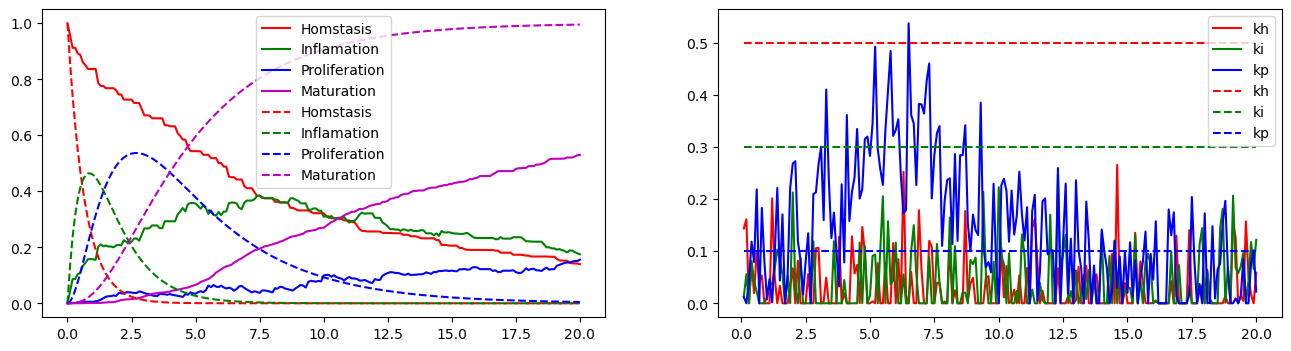

In [10]:
t_span_plt = t_span / 3.0

states_rl_buf, actions_rl_buf = tester(t_span, True)
states_og_buf, actions_og_buf = tester(t_span, False)

fig = plt.figure(figsize=(16, 4), num=2)
ax = fig.add_subplot(121)
ax.plot(t_span_plt, states_rl_buf[:, 0], color='r', linestyle='-', label='Homstasis')
ax.plot(t_span_plt, states_rl_buf[:, 1], color='g', linestyle='-', label='Inflamation')
ax.plot(t_span_plt, states_rl_buf[:, 2], color='b', linestyle='-', label='Proliferation')
ax.plot(t_span_plt, states_rl_buf[:, 3], color='m', linestyle='-', label='Maturation')

ax.plot(t_span_plt, states_og_buf[:, 0], color='r', linestyle='--', label='Homstasis')
ax.plot(t_span_plt, states_og_buf[:, 1], color='g', linestyle='--', label='Inflamation')
ax.plot(t_span_plt, states_og_buf[:, 2], color='b', linestyle='--', label='Proliferation')
ax.plot(t_span_plt, states_og_buf[:, 3], color='m', linestyle='--', label='Maturation')

ax.legend()
ax = fig.add_subplot(122)
ax.plot(t_span_plt[1:], actions_rl_buf[:, 0], color='r', linestyle='-', label='kh')
ax.plot(t_span_plt[1:], actions_rl_buf[:, 1], color='g', linestyle='-', label='ki')
ax.plot(t_span_plt[1:], actions_rl_buf[:, 2], color='b', linestyle='-', label='kp')


ax.plot(t_span_plt[1:], actions_og_buf[:, 0], color='r', linestyle='--', label='kh')
ax.plot(t_span_plt[1:], actions_og_buf[:, 1], color='g', linestyle='--', label='ki')
ax.plot(t_span_plt[1:], actions_og_buf[:, 2], color='b', linestyle='--', label='kp')

ax.legend()
plt.show()

In [11]:
states_rl_buf.shape

(201, 4)

In [ ]:
 args.t_nums